TOPOGRAPHIC MAP ORGANISATION SIMULATION

(From Detorakis and Rougier, 2012)

Neural field theory aims to model neuronal responses at population level, allowing to investigate network dynamics without explicity modeling each neuron. In this work the model of the somatosensory cortex is treated as a 21x21 neuron unit array, where each unit has 256 feed-forward weight values matched with the 256 receptors of the simulated skin patch. The activity of a neuronal unit is determined primarily by two factors:
1. How well the output of the 256 receptors match their coresponding feed-forward weights - the better match, the higher activation
2. What is the net input from lateral connections (local excitatory and distant inhibitory), determined by the firing state of all of the other neuronal units

Initially, the feedforward weights are set to random values and the goal of training is then to achieve topographic organisation, where neighboring neurons in the neural field respond to neighboring stimulation sites on the skin patch. This is essentially achieved by setting lateral connection parameters to only allow a single "activity bump" solution for each stimulation instance - so areas where the are more or stronger responding units excite those closest to them, while units outside the set distance are silenced. These "bump region" units then undergo plasticity changes, modifying their feed-forward wights to more closely match the stimulus pattern that activated them.

During training the neural field is exposed to 121 stimuli located all over the skin patch. Over time, the randomised feed-forward weights become more specialised for matching the receptor output values and, due the bump solution constraint, this means neighboring neuron units learn simillarily shaped receptor patterns, thus exhibiting organisation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift

# constants and parameters
learning_window = 3.0 # learning window of one stimulus
tau_const = 1.0
delta_t = 0.2
gamma = 0.05
alpha = 0.1
Ke = 2.60 
Ki = 1.80 
vare = 2.2 
vari = 15.0
total_receptors = 256

# Initiate Cortical Sheet
x_coords = np.linspace(-10,10, num = 21)
y_coords = np.linspace(-10,10, num = 21)
cortex_coords = [(i,j) for i in x_coords for j in y_coords]
cortex = pd.DataFrame(cortex_coords, columns=["X", "Y"])
# locations of neurons calculated in repect to the center of the cortical sheet
cortex["Location"] = np.sqrt(cortex['X'] ** 2 + cortex['Y'] ** 2)
# initial membrane potentials at 0 for no activity
cortex["U"] = 0
# initial randomised feed-forward weights for each receptor-to-neuron
# 441 neurons (rows) and 256 receptors (columns)
feed_forward = pd.DataFrame(np.random.rand(len(cortex), total_receptors))

FUNCTIONS

- **Firing function:** takes in the specified membrane potential value of neuron x and checks if it is above zero. This serves as the firing threshold, as anything below 0 returns a 0 value
\begin{cases} 
x & \text{if } x \geq 0 \\
0 & \text{if } x < 0 
\end{cases}
- **External input:** computes the external input based on stimuli-specific receptor outputs (s) and the corresponding neuron feed-forward weights (wf). Here the input is considered as the sum of all difference values of receptor-wf connections for neuron x and subracted from 1. While not in the original article, here the receptor-wf difference is weighted by the receptor output to give more imporance to non-zero values

$$
i(x,t) = 1 - \sum_{i=1}^{n} \left( | s_{i} - wf_{i} | \cdot s_{i} \right)
$$

Where n is the number of receptor-feedforward weight pairs, and i is the specific pair

- **Distance matrix:** creates a cortex-sized array where each value represents the simple Eucledian distance from the center. This is done so that the subsequent lateral weight function creates a centered kernel, which can be shifted over all neurons in the firing map.
- **Lateral contributions:** performs fft for spatial convolution. Here the firing map is first extended to contain copies of the firing map all around the region of interest - providing the periodic boundary effect. The kernel is padded to match the firing map and the result is shifted to account for the artifact of using fft. Results are also normalised to match the scale of other values in the model.

The values of excitatory and inhibitory inputs are primarily based on distance and described by:
$$wl(x) = We(x) - Wi(x) = Keexp((-x^2/(2vare)^2)) - Kiexp((-x^2/(2vari)^2))$$
Where Ke, Ki are amplitudes and vare, vari are variances for exc and inhib Gaussian functions; wl, we and wi are lateral, excitatory and inhibitory weights respectively

In [4]:
def firing_function(x):
    return np.maximum(x, 0)

def external_input(match, outputs):
    input_diffs = np.abs(match)
    weighted_diffs = input_diffs * outputs # discard 0 value inputs, extra attention to output peaks
    external_input = 1 - (np.sum(weighted_diffs))
    return external_input

def create_distance_matrix(grid_size):
    """
    Create a 2D distance matrix where each element represents the Euclidean distance from the origin.
    Grid size should match cortex size (assumes square grid)

    Returns:
        np.ndarray: A 2D array of shape (grid_size, grid_size) representing the distance matrix.
    """
    ax = np.arange(-grid_size//2 + 1, grid_size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    distance_matrix = np.sqrt(xx**2 + yy**2)
    return distance_matrix

def create_weight_kernel(distance):
    """
    Create kernels for spatial convolution.

    Returns:
        21x21 lateral weights kernel (excitation-inhibition) and excitatory weights
    """
    ex_weights = Ke * np.exp(-(distance ** 2) / (2 * vare ** 2))
    inh_weights = Ki * np.exp(-(distance ** 2) / (2 * vari ** 2))
    lat_weights = ex_weights - inh_weights
    return lat_weights, ex_weights

# Create Distance Matrix (shape = cortex.shape)
distance_matrix = create_distance_matrix(21)

wl_kernel, _ = create_weight_kernel(distance_matrix)
_, we_kernel = create_weight_kernel(distance_matrix)



def fft_lateral_contributions(firing_map, kernel):
    """
        To enforce periodic boundaries the firing map is copied around the actual 21x21 cortical sheet.
    This allows the sliding kernel to accurately compute lateral contributions for edge neurons,
    taking their nearest neighbor activity as if the cortical sheet was wrapped.

    Returns:
        The convuluted results iare stored in a 21x21 array for the neural field
    """
    map_size = firing_map.shape[0]              # should be 21
    k_size = kernel.shape[0]                    # should be 21
    extended_map = np.tile(firing_map, (3, 3))  # should be 21*3 = 63 (63x63)
    padded_kernel = np.pad(kernel,[(map_size, extended_map.shape[0] - k_size - map_size)], mode='constant')

    map_fft = fft2(extended_map)
    kernel_fft = fft2(padded_kernel)
    result_fft = map_fft * kernel_fft
    result = np.real(ifft2(result_fft))
    result = fftshift(result)
    
    start = map_size -1
    end = extended_map.shape[0] - map_size -1
    result_region = result[start:end, start:end]

    # Normalise post convolution to scale lateral contributions in -1;1 boundaries
    max_value = np.max(np.abs(result_region))
    if max_value != 0:
        result_region /= max_value

    return result_region

**NEURAL FIELD FUNCTION:** this partial differential equation describes the change in the membrane potential at neuronal unit x in the cortex. The decay term -u(x,t) ensures that in the absence of stimuli the membrane potential returns to 0. Lateral connection contribution is calculated by summing up all postion y excitatory and inhibitory influences on x, dependending on firing state from the previous time point. To this external input is added and the membrane potential at position x is updated. This is repeated and calculated for all positions in the cortex before moving on to the time next step

$$
\frac{1}{\tau_{\text{const}}} \frac{\partial u(x,t)}{\partial t} = -u(x,t) + \alpha \left( \int w_l(|x-y|) f(u(y,t)) \, dy + i(x,t) \right)
$$

**LEARNING RULE FOR FEEDFORWARD WEIGHTS**: neural units within the "activity bump" area undergo feed-forward weight change according to the function bellow, which aims to scale the change of the feed-forward weight depending on the difference of the specific receptor-to-feedforward weight pair. If its already a match, there will be little to no chnage, while larger differences indicate that this feed-forward weight needs to adapt for the neural unit to specialise in this stimulus pattern

$$
\frac{d w_f(x, t)}{dt} = \gamma (s(t) - w_f(x)) \cdot \int f(u(y, t)) w_e(|x - y|) \, dy
$$

Where gamma is the learning rate, gamma(s(t)-wf(x)) is the pre-synaptic and the integral of all firing excitatory connections is the post-synaptic component. 

In [7]:
# Initialize recording arrays
num_steps = int(learning_window / delta_t)
holding_U = np.zeros(len(cortex))
holding_Wf = np.zeros((len(cortex), total_receptors))


def simulation(applied_stimulus, cortex_df, feed_forward_df, receptor_outputs, neuron, track_stim):
    """
        The main simulation loop. Within each loop a stimulus is applied for the duration of the learning window and is removed (neuron field activity reset
    to 0) at the end. For each time_step within the learning window the firing map is construced based on previous time_step activity and is used to get contribution
    values. Membrane potential change and the feed-forward weight updates for each neuron are stored in temporary holding arrays, only updating the cortex 
    array values once all neurons are cycled through. Additionally, there is an option to track feed-forward weight evolution of a sepciefied neuron and
    stimulus/i

    RETURNS
        Returns updated feed-forward array (the learned weights) in a 441x256 array; returns tracked neuron feed-forward weights before and after training
        for specified stimulus/i in a 2x256 array
    """
    # stimulus-relevenat receptor outputs
    current_stim_outputs = receptor_outputs[receptor_outputs["Stimulus_Index"] == applied_stimulus]
    outputs = current_stim_outputs["Output"].values
    wf_tracking = []

    if applied_stimulus in track_stim:
        initial_wf = feed_forward_df.iloc[neuron].values.copy()

    for time_step in range(num_steps):
        firing = cortex_df["U"].values
        firing_map = np.vectorize(firing_function)(firing).reshape(21,21).T[::-1]
        lat_contributions = fft_lateral_contributions(firing_map, wl_kernel)[::-1].T.flatten()
        excitatory_contributions = fft_lateral_contributions(firing_map, we_kernel)[::-1].T.flatten()

        # cycle through neurons
        for x in range(len(cortex_df)): 
            # get receptor output - wf difference
            input_match = outputs - feed_forward_df.iloc[x].values

            # updating all neuron membrane potential values one by one
            syn_input = external_input(input_match, outputs)
            lat_contr_x = lat_contributions[x]
            holding_U[x] = delta_t * ((-cortex_df.loc[x, "U"]) + (lat_contr_x + syn_input)) * tau_const

            # updating all feed-forward weights for neuron x
            presynaptic_terms = gamma * input_match
            postynaptic_term = excitatory_contributions[x]
            holding_Wf[x] = delta_t * (presynaptic_terms * postynaptic_term) # 1x256 row
        
        # Apply the updates after processing all neurons
        cortex_df["U"] += holding_U
        feed_forward_df += holding_Wf
        
    if applied_stimulus in track_stim:
        final_wf = feed_forward_df.iloc[neuron].values.copy()
        wf_tracking = np.vstack((initial_wf, final_wf))

    # take away pressure simulus - return all membrane values to 0
    cortex_df["U"] = 0
    return feed_forward_df, wf_tracking

The following cell is used to run the simulation loop. You can select:
1. The relevant recptor output file. For more dynamic learning, different sets of receptor outputs can be used (if receptor location stays the same, only changing stimuli coordinates)
2. If needed for analysis, there is an option to track the feed-forward weight evolution for a single neuronal unit and for specific stimuli

As the output you get a .csv file containing the pre-stim-set feed-forward values stacked above the post-stim-set values. The tracked neuron .csv file stores the specific feed-forawrd weights before and after the application of the specified stimuli (stacked as the pre- and post-stim-set file)

In [7]:
# import and process receptor outputs
receptor_outputs = pd.read_csv("receptor_outputs_1.csv")

# specify tracking values
# track wfs of neuron x before and after applying specified stims
tracking_neuron = 152
tracking_stims = [14]

randomised_stims = np.random.permutation(121) # randomisation avoids training location bias
before_wf = feed_forward.values # 1st wfs before stim set learning
for i in randomised_stims:
    after_wf, tracking_wf = simulation(i, cortex, feed_forward, receptor_outputs, tracking_neuron, tracking_stims)
    if i in tracking_stims:
        pd.DataFrame(tracking_wf).to_csv(f"tracking_wf51_n{tracking_neuron}_s{tracking_stims}.csv", index=False)
feed_forward_array = np.vstack((before_wf, after_wf))
pd.DataFrame(feed_forward_array).to_csv(f"pre_post_wfs_per_set51.csv", index=False)

**RESULTS**

The main objective of the trained model is exhibit organisation - where neighboring neurons in the cortex respond to neighboring stimuli on the skin patch. 

**Section 1:** heatmap represents neural field response to single stimulus

In the first section (Single stimulus aplication) this can be seen when a single specified stimulus is applied and the neural unit responses are plotted on a heatmap representing the neural field at each time step. These figures show a distinct bump of activity in the neural field, which is sharpened and defined as the stimulation is applied. This indicates that a single stimulus evokes local corical activity.

**Section 2:** heatmap represents full stimuli set evoked activity for a single neuron

The second section (Single neuron response to all stimuli) shows how a neuron responds to the full stimuli set. Here, if you plot the resulting activity array heatmaps for a group of neighboring neurons, you can see they respond to roughly the same location of skin patch stimulation.


Selected stimulus (section 1) or sequentially presented stimuli (section 2) are applied for a period of time to allow network dynamics to sharpen the response. This mimics how biologically a response would be shaped by lateral connections, as realistically stimulation would not be instantaneous. 

In [ ]:
# for setting the trained model feed-forward weights
weights = pd.read_csv("pre_post_wfs_per_set51.csv")
feed_forward = weights.iloc[441: ,]

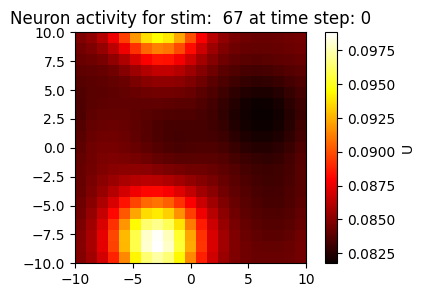

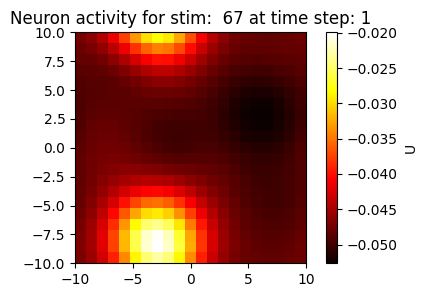

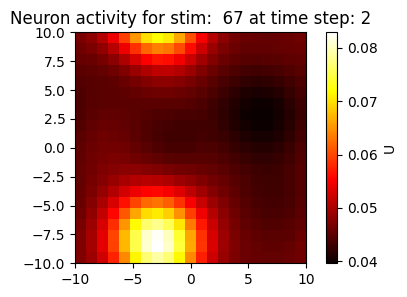

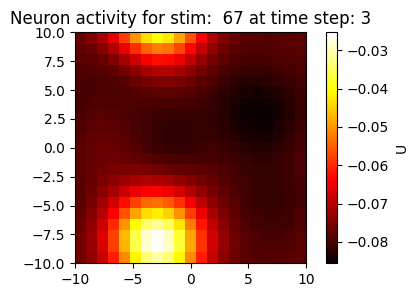

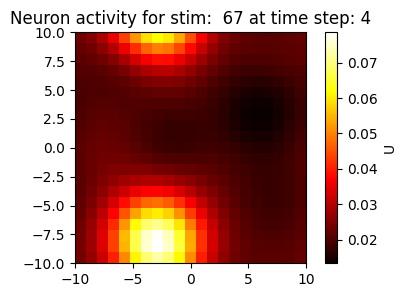

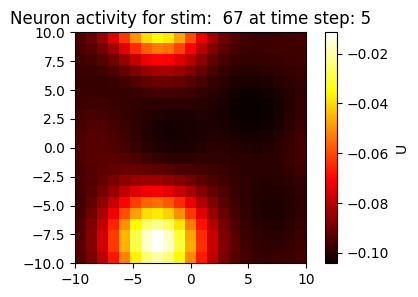

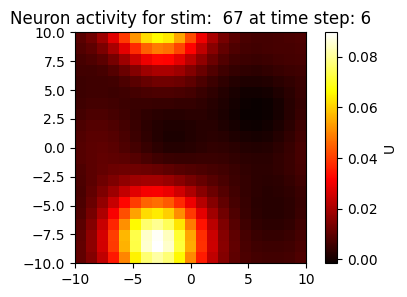

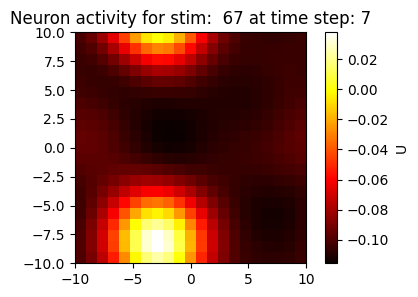

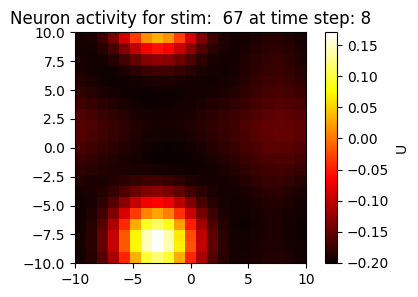

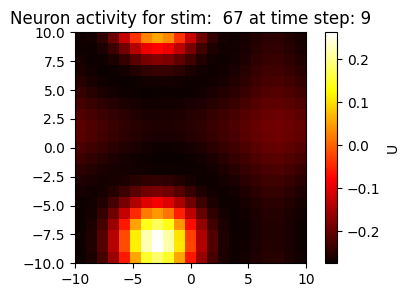

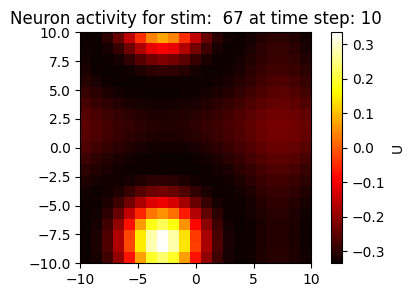

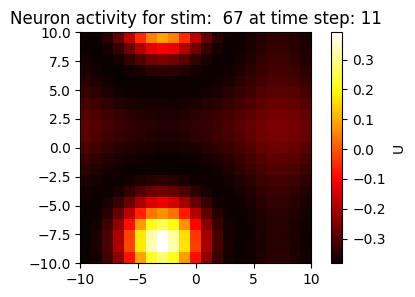

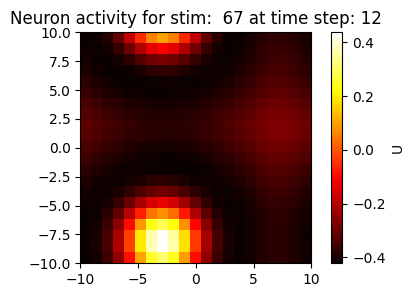

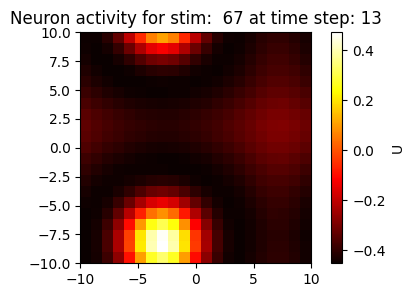

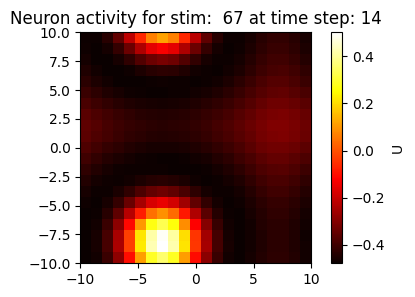

In [93]:
""" SECTION 1: SINGLE STIMULUS APPLICATION """
stim = 67
time_steps = 15 # arbitrarily chosen, stable results can be seen from time_step 10 onwards

def prolonged_single_stimulation(stim, time_steps, receptor_outputs):
    """
        Function retrieves receptor output information for the selected stimulus, generates a
    firing map for lateral contribution calculation and applies the stimulus to all neurons.
    Since there is no plasticity rule present, the shape of the response is only influenced by 
    external input recieved (based on receptor output and feed-forward value match) and further
    sharpened by network dynamics (lateral contributions) resulting in a well defined area of activity

    RETURNS
        A heatmap of the each neural unit response to a stimulus in each time step. Since there
    is no plasticity rule present, the shape of the response is only influenced by external input
    recieved (based on receptor output and feed-forward value match) and further sharpened by
    network dynamics (lateral contributions) resulting in a well defined area of activity
    """
    
    current_stim_outputs = receptor_outputs[receptor_outputs["Stimulus_Index"] == stim]
    outputs = current_stim_outputs["Output"].values

    cortex["U"] = 0 # initiate zero activity cortex
    holding_u = np.zeros(len(cortex))

    for time in range(time_steps):
        firing = cortex["U"].values
        firing_map = np.vectorize(firing_function)(firing).reshape(21,21).T[::-1]
        lat_contributions = fft_lateral_contributions(firing_map, wl_kernel)[::-1].T.flatten()

        for x in range(len(cortex)):
            match = outputs - feed_forward.iloc[x].values

            ex_in = external_input(match, outputs)
            previous_u = cortex.loc[x, "U"]
            holding_u[x] = previous_u + delta_t * ((-previous_u) + lat_contributions[x] + ex_in)

        cortex["U"] = holding_u

        plt.figure(figsize=(5,3))
        plt.imshow(cortex["U"].values.reshape(21,21).T, extent=[-10, 10, -10, 10], cmap='hot', origin='lower')
        plt.colorbar(label="U")
        plt.title(f'Neuron activity for stim: {stim} at time step: {time}')

    plt.show()
    plt.close()
    cortex["U"] = 0

prolonged_single_stimulation(stim, time_steps, receptor_outputs)

In [94]:
""" SECTION 2: SINGLE NEURON (OR A GROUP) RESPONSE TO ALL STIMULI"""

def activity_map(number_of_stims, receptor_outputs):
    """
        Function cycles through stims sequentially, applying a stimulus for the set time period
    for all neurons. At the end of each time step the membrane potential values are updated
    in the activty array to form the next firing map or the end activity result. The order of the stim
    responses are stored in a way that preserves the stimulus spatial relationship (as it was on 
    the skin patch) when visualised in a heatmap.

    Results:
        A 441x121 array, where each row holds the activity of a neuron unit in response to all 
    stimuli and every column is all neuron response to a single stimulus (only after full time period, 
    as opposed to section 1 which visualised each time step). In the heatmaps you can see that 
    a group of neighboring neurons respond to neighboring stimuli.
    """
    activity_array = np.zeros((len(cortex), number_of_stims))
    num_steps = 30

    for stim in range(number_of_stims):
        current_stim_outputs = receptor_outputs[receptor_outputs["Stimulus_Index"] == stim]
        outputs = current_stim_outputs["Output"].values

        # applying a single stimulus to all neurons for a time period
        # result of each neuron is placed in the activity_array
        for time_step in range(num_steps):
            firing = activity_array[:, stim]
            firing_map = np.vectorize(firing_function)(firing).reshape(21,21).T[::-1] # convert to 2D for FFT
            lat_contributions = fft_lateral_contributions(firing_map, wl_kernel)[::-1].T.flatten() # flatten back to 1D

            holding_u = np.zeros(len(cortex))
                
            for neuron in range(len(cortex)):
                input_match = outputs - feed_forward.iloc[neuron].values
                syn_input = external_input(input_match, outputs)
                lat_contr_x = lat_contributions[neuron]
                previous_u = activity_array[neuron, stim]
                holding_u[neuron] = delta_t * ((- previous_u) + (lat_contr_x + syn_input))
                
            activity_array[:, stim] += holding_u
        
    return activity_array


In [95]:
number_of_stims = 121
activity_array = activity_map(number_of_stims, receptor_outputs)

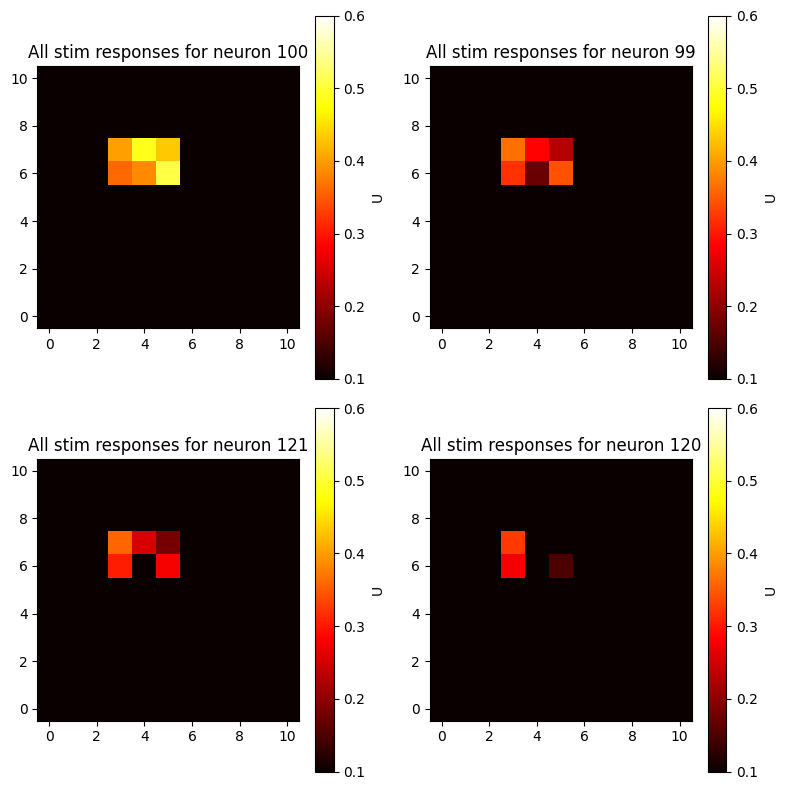

In [96]:
# define which neurons to investigate
neuron_list = [100, 99, 121, 120]

counter = 0
plt.figure(figsize=(8,8))

for neuron in neuron_list:
    neuron_activity = activity_array[neuron, :].reshape((11,11)).T
    counter += 1

    plt.subplot(2, 2, counter)
    plt.imshow(neuron_activity, cmap='hot', origin='lower', vmin = 0.1, vmax = 0.6)
    plt.colorbar(label="U")
    plt.title(f'All stim responses for neuron {neuron}')

plt.tight_layout()
plt.show()
plt.close()